In [ ]:
pip install num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 7.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=039ccb996b456ba46fc051ffb3c3099f3156b51bc3cbe3ea60e7c35523e4d64a
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt


In [ ]:
import re

import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


100%|██████████| 170M/170M [00:03<00:00, 45.6MB/s]


This is a frog image


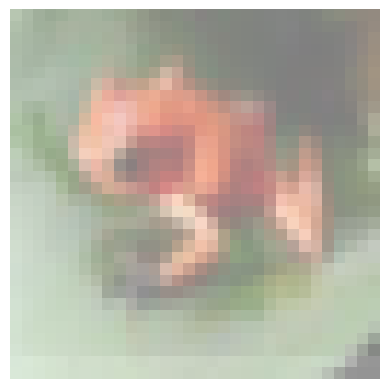

In [ ]:


# Download CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# CIFAR10 classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to display image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Select a random image from CIFAR10
import random
index = random.randint(0, len(trainset))
image, label = trainset[index]

# Display the image
print(f"This is a {classes[label]} image")
imshow(image)

# Save the image for later use with SmolVLM2
img_np = np.transpose(image.numpy(), (1, 2, 0))
img_np = (img_np * 255).astype(np.uint8)
img_pil = Image.fromarray(img_np)
img_pil.save('cifar10_sample.jpg')

In [ ]:
# Cell 2: Import libraries and load SmolVLM2 model
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText
import warnings
import random
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# Suppress specific warnings if necessary (optional)
warnings.filterwarnings("ignore", category=FutureWarning)

# Define the model path
model_path = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"

# Check for GPU and flash attention support
device = "cuda" if torch.cuda.is_available() else "cpu"
# Use bfloat16 if on CUDA and supported, otherwise float32
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float32

attn_implementation = "sdpa" # Default attention
try:
    import flash_attn
    if torch.cuda.get_device_capability()[0] >= 8: # Check if GPU architecture supports flash attention 2
       attn_implementation = "flash_attention_2"
       print("Flash Attention 2 is available and will be used.")
    else:
       print("Flash Attention 2 requires Ampere GPU or newer. Using SDPA instead.")
except ImportError:
    print("Flash Attention 2 library not found. Using SDPA instead.")

print(f"Using device: {device}")
print(f"Using dtype: {dtype}")
print(f"Using attention implementation: {attn_implementation}")


# attn_implementation = "flash_attention_2"


try:
    # Load the SmolVLM2 processor
    smol_processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)
    print("SmolVLM2 Processor loaded successfully.")

    # Load the SmolVLM2 model
    smol_model = AutoModelForImageTextToText.from_pretrained(
        model_path,
        torch_dtype=dtype,
        # _attn_implementation=attn_implementation,
        trust_remote_code=True
    ).to(device)
    print(f"SmolVLM2 Model loaded successfully to {device} with {dtype}.")

except Exception as e:
    print(f"Error loading SmolVLM2 model or processor: {e}")
    raise SystemExit("SmolVLM2 Model loading failed.")

Flash Attention 2 library not found. Using SDPA instead.
Using device: cuda
Using dtype: torch.bfloat16
Using attention implementation: sdpa


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


SmolVLM2 Processor loaded successfully.


config.json:   0%|          | 0.00/3.64k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/63.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.03G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

SmolVLM2 Model loaded successfully to cuda with torch.bfloat16.


In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg"},
            {"type": "text", "text": "Can you describe this image?"},
        ]
    },
]

inputs = smol_processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(smol_model.device, dtype=torch.bfloat16)

generated_ids = smol_model.generate(**inputs, do_sample=False, max_new_tokens=64)
generated_texts = smol_processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)
print(generated_texts[0])

User:



Can you describe this image?
Assistant: The image depicts a close-up view of a bee on a pink flower. The bee is positioned in the center of the flower, with its body prominently displayed. The flower itself is vibrant and has a prominent pink hue, with a yellow center that is slightly visible. The petals of the flower are slightly curled,



--- Downloading CIFAR-10 Dataset ---
CIFAR-10 dataset downloaded/loaded successfully.

Selected image index: 8877
This is a frog image.
Image saved as 'cifar10_sample.jpg'

Displaying the selected image:


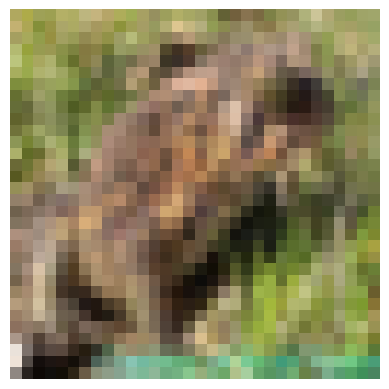


--- Processing saved image 'cifar10_sample.jpg' with SmolVLM2 ---
Successfully loaded image: cifar10_sample.jpg
Messages payload prepared for SmolVLM2.
Inputs processed using SmolVLM2 chat template.
Generating description with SmolVLM2...

--- SmolVLM2 Generated Output ---
User:




You are very observant, just like a detective. Look at this image very closely, this might be blur but still conveys a lot of information. Try your best to gather whatever you can from the image and say 5 to 10 distinct things about it.
Assistant: a brown lizard on the ground
@@@@@ Parts ['User:\n\n\n\n\nYou are very observant, just like a detective. Look at this image very closely, this might be blur but still conveys a lot of information. Try your best to gather whatever you can from the image and say 5 to 10 distinct things about it.\nAssistant: a brown lizard on the ground']
a deer standing on the ground with a green background


In [ ]:
#

# print("Libraries installation attempted.")





# Cell 3: Download CIFAR-10, select, display, and save a random image
print("\n--- Downloading CIFAR-10 Dataset ---")
# Define a transform to convert images to PyTorch tensors (range [0, 1])
cifar_transform = transforms.Compose([transforms.ToTensor()])

# Download CIFAR10 training dataset
try:
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
    print("CIFAR-10 dataset downloaded/loaded successfully.")
except Exception as e:
    print(f"Error downloading CIFAR-10 dataset: {e}")
    raise SystemExit("CIFAR-10 download failed.")

# CIFAR10 classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Select a random image from CIFAR10 training set
index = random.randint(0, len(trainset) - 1)
image_tensor, label = trainset[index] # image_tensor is in [0, 1] range

print(f"\nSelected image index: {index}")
print(f"This is a {classes[label]} image.")

# --- Convert tensor to PIL Image and save it ---
# Convert tensor shape (C, H, W) to (H, W, C) for numpy/PIL
img_np = np.transpose(image_tensor.numpy(), (1, 2, 0))
# Convert range [0, 1] to [0, 255] and change type to uint8
img_np = (img_np * 255).astype(np.uint8)
# Create PIL image from numpy array
img_pil = Image.fromarray(img_np)

# Define the filename for the saved image
saved_image_filename = 'cifar10_sample.jpg'
img_pil.save(saved_image_filename)
print(f"Image saved as '{saved_image_filename}'")

# Display the PIL image (this is the exact image that will be fed to SmolVLM2)
print("\nDisplaying the selected image:")
plt.imshow(img_pil)
plt.axis('off')
plt.show()


# Cell 4: Load the saved image and process with SmolVLM2
print(f"\n--- Processing saved image '{saved_image_filename}' with SmolVLM2 ---")

try:
    # Load the SAVED image using Pillow (this ensures we use the exact saved version)
    raw_image_from_file = Image.open(saved_image_filename).convert('RGB')
    print(f"Successfully loaded image: {saved_image_filename}")

    # --- Prepare the messages payload for SmolVLM2 ---
    messages = [
        {
            "role": "user",
            "content": [
                # Pass the loaded PIL image object
                {"type": "image", "image": raw_image_from_file},
                # The text prompt asking for 5-10 things
                {"type": "text", "text": "You are very observant, just like a detective. Look at this image very closely, this might be blur but still conveys a lot of information. Try your best to gather whatever you can from the image and say 5 to 10 distinct things about it."},
            ]
        },
    ]
    print("Messages payload prepared for SmolVLM2.")

    # Process the inputs using the SmolVLM2 chat template
    inputs = smol_processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(smol_model.device, dtype=dtype) # Ensure inputs match model device and dtype
    print("Inputs processed using SmolVLM2 chat template.")

    # Generate the description using SmolVLM2
    print("Generating description with SmolVLM2...")
    generated_ids = smol_model.generate(**inputs, do_sample=False, max_new_tokens=200)

    # Decode the generated text
    generated_texts = smol_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )

    print("\n--- SmolVLM2 Generated Output ---")
    full_response = generated_texts[0].strip()
    print(full_response)

    # Try to extract only the assistant's response
    # Adjust the splitting logic if the actual output format differs
    parts = full_response.split("assistant") # Simple split
    print('@@@@@ Parts',parts)


    # input_list = ["User:\n\n\n\n\nYou are very observant, just like a detective. Look at this image very closely, this might be blur but still conveys a lot of information. Try your best to gather whatever you can from the image and say 5 to 10 distinct things about it.\nAssistant: a blurry picture of a car in the woods"]

    # Use regex to capture everything after 'Assistant:'
    match = re.search(r'Assistant:\s*(.*)', parts[0])

    if match:
        assistant_response = match.group(1)
        print(result)
    else:
        print("No match found.")



except FileNotFoundError:
    print(f"Error: Saved file '{saved_image_filename}' not found. Check Cell 3 execution.")
    raise SystemExit("Image loading failed.")
except Exception as e:
    print(f"An error occurred during SmolVLM2 image loading, processing, or generation: {e}")
    if "out of memory" in str(e).lower():
        print("CUDA Out of Memory error with SmolVLM2.")
    raise SystemExit("SmolVLM2 processing or generation failed.")


In [ ]:
import warnings
import random
import numpy as np
import csv
import os
import time # For progress updates

# Suppress specific warnings if necessary (optional)
warnings.filterwarnings("ignore", category=FutureWarning)


# --- Configuration ---
OUTPUT_CSV_FILENAME = 'cifar10_smolvlm2_results.csv'
DATASET_ROOT = './data'
USE_TEST_SET = True # Set to False to use the training set (50k images)


# Define transform (just ToTensor, as model processor handles normalization)
cifar_transform = transforms.Compose([transforms.ToTensor()])

# Load CIFAR10 dataset
try:
    dataset = torchvision.datasets.CIFAR10(
        root=DATASET_ROOT,
        train=(not USE_TEST_SET),
        download=True,
        transform=cifar_transform
    )
    print(f"CIFAR-10 {'Test' if USE_TEST_SET else 'Train'} set loaded successfully. Size: {len(dataset)} images.")
except Exception as e:
    print(f"Error loading CIFAR-10 dataset: {e}")
    raise SystemExit("CIFAR-10 loading failed.")



In [ ]:
PROGRESS_INTERVAL = 50 # Print progress every N images

In [ ]:


# CIFAR10 classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Cell 4: Resumption Logic and Main Processing Loop
print(f"\n--- Starting Inference Process ---")
print(f"Results will be saved to: {OUTPUT_CSV_FILENAME}")

start_index = 0
processed_indices = set()

# --- Resumption Logic ---
if os.path.exists(OUTPUT_CSV_FILENAME):
    try:
        with open(OUTPUT_CSV_FILENAME, 'r', newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader) # Skip header
            for row in reader:
                if row: # Ensure row is not empty
                   processed_indices.add(int(row[0])) # Add index from first column
        if processed_indices:
            start_index = max(processed_indices) + 1
            print(f"Resuming from index {start_index}. Found {len(processed_indices)} previously processed images.")
        else:
             print("Output file exists but is empty or has no valid indices. Starting from index 0.")
             # If file exists but is empty/corrupt, rewrite header later
             start_index = 0
             processed_indices = set() # Reset just in case
             # Overwrite the file to ensure clean start if it was corrupt
             with open(OUTPUT_CSV_FILENAME, 'w', newline='', encoding='utf-8') as csvfile:
                 writer = csv.writer(csvfile)
                 writer.writerow(['image_index', 'class_label_index', 'class_label_name', 'generated_text'])
             print("Output file was potentially corrupt, recreated with header.")

    except Exception as e:
        print(f"Error reading existing CSV file '{OUTPUT_CSV_FILENAME}': {e}. Starting from index 0.")
        start_index = 0
        processed_indices = set()
        # Attempt to overwrite with header
        try:
             with open(OUTPUT_CSV_FILENAME, 'w', newline='', encoding='utf-8') as csvfile:
                 writer = csv.writer(csvfile)
                 writer.writerow(['image_index', 'class_label_index', 'class_label_name', 'generated_text'])
        except Exception as write_e:
             print(f"Could not write header to output file: {write_e}")
             raise SystemExit("Failed to prepare output file.")


# Write header if starting from scratch (file didn't exist or was recreated)
if start_index == 0 and not os.path.exists(OUTPUT_CSV_FILENAME):
     try:
        with open(OUTPUT_CSV_FILENAME, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['image_index', 'class_label_index', 'class_label_name', 'generated_text'])
        print("Created new output file with header.")
     except Exception as e:
          print(f"Error creating output file '{OUTPUT_CSV_FILENAME}': {e}")
          raise SystemExit("Failed to create output file.")


# --- Main Processing Loop ---
total_images = len(dataset)
start_time = time.time()

# Open file in append mode outside the loop
try:
    with open(OUTPUT_CSV_FILENAME, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)

        for i in range(start_index, total_images):
            # Skip if already processed (double check for safety, though loop starts after last processed)
            if i in processed_indices:
                continue

            current_time = time.time()
            elapsed = current_time - start_time
            img_rate = (i - start_index + 1) / elapsed if elapsed > 0 else 0
            eta = (total_images - i - 1) / img_rate if img_rate > 0 else float('inf')

            if (i - start_index) % PROGRESS_INTERVAL == 0:
                print(f"Processing image {i}/{total_images-1} (Index: {i}). Elapsed: {elapsed:.1f}s. Rate: {img_rate:.2f} img/s. ETA: {eta/60:.1f} mins.")

            try:
                # 1. Get image and label
                image_tensor, label_index = dataset[i]
                label_name = classes[label_index]

                # 2. Convert tensor to PIL Image (in memory)
                img_np = np.transpose(image_tensor.numpy(), (1, 2, 0))
                img_np = (img_np * 255).astype(np.uint8)
                img_pil = Image.fromarray(img_np).convert('RGB') # Ensure RGB

                # 3. Prepare prompt and inputs for SmolVLM2
                messages = [
                    {
                        "role": "user",
                        "content": [
                            {"type": "image", "image": img_pil},
                            {"type": "text", "text": "Look at this image. Describe this image in detail. Please say 5 to 10 distinct things about it."},
                            # Alternative prompt: "Describe this image in detail."
                        ]
                    },
                ]
                inputs = smol_processor.apply_chat_template(
                    messages, add_generation_prompt=True, tokenize=True,
                    return_dict=True, return_tensors="pt",
                ).to(smol_model.device, dtype=dtype)

                # 4. Generate text (with specific error handling)
                try:
                    generated_ids = smol_model.generate(**inputs, do_sample=False, max_new_tokens=200)
                    # Decode
                    generated_texts = smol_processor.batch_decode(generated_ids, skip_special_tokens=True)
                    full_response = generated_texts[0].strip()
                    # Extract assistant response (simple split, adjust if needed)
                    # print(full_response)
                    match = re.search(r'Assistant:\s*(.*)',full_response)

                    if match:
                        assistant_response = match.group(1)
                        # print(assistant_response)
                    else:
                        assistant_response = full_response

                    # parts = full_response.split("assistant")
                    # assistant_response = parts[-1].strip().lstrip(':').strip() if len(parts) > 1 else full_response

                except Exception as gen_e:
                     print(f"  ERROR generating text for index {i}: {gen_e}")
                     # Write error to CSV instead of description
                     assistant_response = f"GENERATION_ERROR: {str(gen_e)}"
                     # Optionally: continue # Skip saving this row if you prefer

                # 5. Append result to CSV immediately
                writer.writerow([i, label_index, label_name, assistant_response])
                csvfile.flush() # Ensure data is written to disk

                # Optional: Add a small delay if needed to prevent rate limiting or overheating
                # time.sleep(0.1)

            except Exception as loop_e:
                print(f"  UNEXPECTED ERROR processing index {i}: {loop_e}. Skipping.")
                # Optionally write a different error type to CSV or log elsewhere
                writer.writerow([i, label_index, label_name, f"PROCESSING_ERROR: {str(loop_e)}"])
                csvfile.flush()
                continue # Move to the next image

except IOError as e:
    print(f"FATAL ERROR: Could not write to CSV file '{OUTPUT_CSV_FILENAME}': {e}")
    raise SystemExit("CSV write error.")

end_time = time.time()
print(f"\n--- Processing Finished ---")
print(f"Processed images from index {start_index} to {total_images - 1}.")
print(f"Total time taken: {(end_time - start_time):.2f} seconds.")
print(f"Results saved in '{OUTPUT_CSV_FILENAME}'.")


--- Starting Inference Process ---
Results will be saved to: cifar10_smolvlm2_results_batch8.csv
Resuming from index 184. Found 184 previously processed images.
Processing image 184/9999 (Index: 184). Elapsed: 0.0s. Rate: 73.47 img/s. ETA: 2.2 mins.
Processing image 234/9999 (Index: 234). Elapsed: 429.5s. Rate: 0.12 img/s. ETA: 1370.5 mins.
Processing image 284/9999 (Index: 284). Elapsed: 870.0s. Rate: 0.12 img/s. ETA: 1394.7 mins.
Processing image 334/9999 (Index: 334). Elapsed: 1302.3s. Rate: 0.12 img/s. ETA: 1389.2 mins.
Processing image 384/9999 (Index: 384). Elapsed: 1730.9s. Rate: 0.12 img/s. ETA: 1380.0 mins.
